# 使用 Spotpy

根据[spotpy](https://github.com/thouska/spotpy)的介绍，它是一个支持模型率定及不确定性和灵敏度分析中优化技术的python框架，其简单性和灵活性使得无需复杂的代码就可以针对各类模型使用各种算法。

这里主要结合实例介绍其中水文领域经常用到的一个优化算法 SCE-UA的使用，后面再根据实际使用情况更新补充。

因为本文主要以SCE-UA为例，所以不必须贝叶斯推断相关知识，不过如果想要进一步使用 spotpy，必要的知识背景是不可少的，下面介绍框架也有一些术语涉及到了，可以参考以下资料：

- [CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/tree/master/)
- [OuyangWenyu/hydro-bayes-mcmc（暂未完成）](https://github.com/OuyangWenyu/hydro-bayes-mcmc)

## Spotpy 简介

先了解下 Spotpy的基本情况。参考资料如下

- [SPOTting Model Parameters Using a Ready-Made Python Package](https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0145180)
- [thouska/spotpy文档](https://spotpy.readthedocs.io/en/latest/)

Spotpy主要包括以下几个低耦合的模块：

![](pictures/QQ截图20210923111220.png)

第一部分是参数分布的设置，由于一般目标函数的复杂性，直接确定性地优化是困难地，所以优化比较多的还是使用概率类的，即采样然后分析计算再来更新参数，这样来探索函数的最优值。常用的先验分布有均匀分布、正态分布、指数分布、Gamma分布等；

第二，就是调用给定的模型接口计算，即simulation，以及对观测的读取，即evaluation；

接下来是设置目标函数，即衡量simulation拟合evaluation数据有多好，以用于后续优化，常用的指标包括 确定性系数、相关系数、协方差、均方根误差等；

接着就可以执行优化算法估计参数了，包含的算法有：蒙特卡洛法、拉丁超立方法、GLUE法、MLE法、Metropolis MCMC法、SCE-UA法、DE-MC$_Z$等；

然后，每个参数估计方法的结果都会被存入数据库（sqlite3）或者csv、hdf5等文件，用于后续分析

最后是分析模块，能读取前步存储的数据库，并做可视化分析，以及后验分布采样等

接下来就看看一些实例，学习如何使用这个工具，原代码在[这里](https://github.com/thouska/spotpy/tree/master/spotpy/examples)。

先看一个相对简单的函数Rosenbrock的例子，了解下基本使用方法。

Rosenbrock 函数是常用的比较优化方法使用的标准函数，其表达式为：

$$f_{Rosen}(x,y)=(1-x)^2+100(y-x^2)^2$$

图像如下所示（图中数据取值范围是$x\in [-10,10], y\in [-10,10]$）：

![](pictures/QQ截图20210923114554.png)

下面例子是一个三维的函数，所以目标是找到0输出对应的x、y和z值。

首先，导入相应的仓

In [4]:
import numpy as np
import spotpy
from spotpy.parameter import Uniform
from spotpy.objectivefunctions import rmse
from spotpy.describe import describe

然后设置好simulation的模型。

假设我们不知道关于x和y的信息，所以我们选择均匀分布。

In [9]:
class spot_setup(object):
    """
    A 3 dimensional implementation of the Rosenbrock function
    Result at (1,1,1) is 0.
    """
    x = Uniform(-10, 10, 1.5, 3.0, -10, 10, doc='x value of Rosenbrock function')
    y = Uniform(-10, 10, 1.5, 3.0, -10, 10, doc='y value of Rosenbrock function')
    z = Uniform(-10, 10, 1.5, 3.0, -10, 10, doc='z value of Rosenbrock function')
    
    def __init__(self,obj_func=None):
        self.obj_func = obj_func
    
    def simulation(self, vector):
        x=np.array(vector)
        simulations= [sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1 - x[:-1]) ** 2.0)]
        return simulations
        
    def evaluation(self):
        observations = [0]
        return observations
    
    def objectivefunction(self, simulation, evaluation, params=None):

        #SPOTPY expects to get one or multiple values back, 
        #that define the performence of the model run
        if not self.obj_func:
            # This is used if not overwritten by user
            like = rmse(evaluation,simulation)
        else:
            #Way to ensure on flexible spot setup class
            like = self.obj_func(evaluation,simulation)    
        return like

下面就可以尝试调用spotpy的代码了。

分析采样结果的一种方法是查看采样参数的目标函数迹。

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  1000  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'RosenSCEUA.csv' created.
Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...
ComplexEvo loop #2 in progress...
ComplexEvo loop #3 in progress...
ComplexEvo loop #4 in progress...
ComplexEvo loop #5 in progress...
ComplexEvo loop #6 in progress...
ComplexEvo loop #7 in progress...
ComplexEvo loop #8 in progress...
ComplexEvo loop #9 in progress...
ComplexEvo loop #10 in progress...
ComplexEvo loop #11 in progress...
ComplexEvo loop #12 in progress...
ComplexEvo loop #13 in progress...
ComplexEvo loop #14 in progress...
Skipping saving
Skipping saving
Skipping saving
Skipping saving
Skipping saving
Skipping saving
Skipping saving
Skipping saving
Skipping saving
Skipping saving
Skipping saving
Skipping 

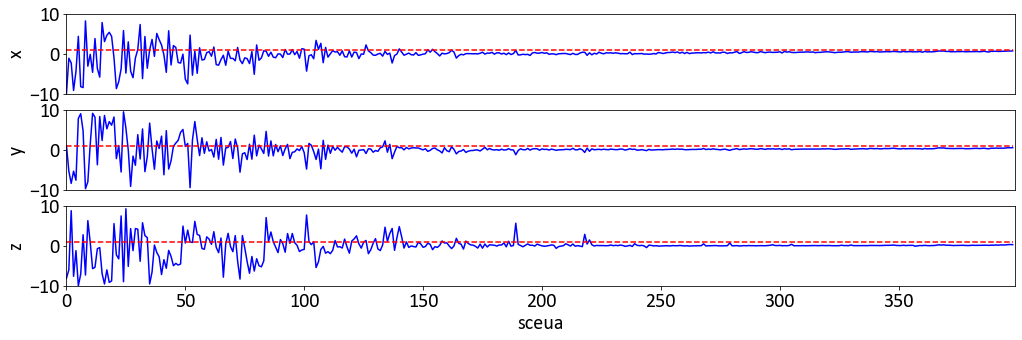

In [12]:
#Create samplers for every algorithm:
results=[]
rep=1000
timeout=10 #Given in Seconds

parallel = "seq"
dbformat = "csv"

sampler=spotpy.algorithms.sceua(spot_setup(),
                                parallel=parallel, dbname='RosenSCEUA', dbformat=dbformat, sim_timeout=timeout)
sampler.sample(rep,ngs=4)
results.append(sampler.getdata())

print(results[0].dtype) # Check for Travis: Get the last sampled parameter for x
evaluation = spot_setup().evaluation()

# Example how to plot the data
algorithms = ['sceua']
spotpy.analyser.plot_parametertrace_algorithms(results, algorithms, spot_setup())

## 使用SCE-UA率定HYMOD模型

下面参考[Effective and efficient global optimization for conceptual rainfall‐runoff models](https://onlinelibrary.wiley.com/doi/full/10.1029/91WR02985)，简单概括下SCE-UA算法的步骤，然后用一个简单的水文模型例子展示如何使用它率定。

优化算法中处理多个局部最优的思路之一就是跑多次优化实验，道理是如果一次不达标有一定概率，那从多个不同独立随机初始点跑然后都失败的概率是很小的，所以SCE-UA（shuffeld complex evolution algorithm）的思路就是一开始就要从可行空间中随机选择很多点来跑，这些点总体称为一个种群。

SCE-UA将这些点分成一系列complex，p表示complex的数目，每个complex中的点数是m，这俩数提前设定好，所以就有s=mp个样本点，随机从初始分布中抽取。

然后就可以计算这些点的目标函数值了，计算后排序，再将这些点等间距分成p个complex，每个还是m个点，就相当于这些点有新位置了。

接下来使用一个进化算法（Competitive Complex Evolution，CCE）来更新进化每个complex，这个算法基本逻辑是使用[simplex](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method)（不是线性规划里面那个单纯形法）几何形状来指引搜索走向改进优化的方向。

如果种群中每个点都自己跑自己的，那互相之间就没有信息交流，这样效率是低的，为了提高运算效率，一个方式就是重新洗牌种群，所以接着就 shuffle下这些complexes，将更新后的complex依次放入D中，然后按函数值重新排序。

接着就检查收敛度，满足就停止，不满足就从重新将点划分成p个complex，然后进化，shuffle，循环直到满足。

HYMOD是一个比较简单的流域水文模型，其结构如下

![](pictures/QQ截图20210923163917.png)

产流部分和新安江模型类似，就是一个蓄水容量曲线，降水超过蓄水容量的部分就产流，汇流的话分两块，快速流是三个串联的线性水库，慢流是一个线性水库。

代码在hymod_python文件夹下。

下面将它们整合起来。

基本上任何模型都可以链接到 SPOTPY，只要它可以用 Python 以某种方式启动。将模型链接到 SPOTPY 是通过以下连续步骤完成的，这些步骤都在一个 spotpy_setup 类中。如果遵循这些步骤，SPOTPY 可以使用这个类并以自动化方式分析模型。

第一步，导入相关的包，生成一个spotpy setup类

In [31]:
from hymod_python.hymod import hymod
import os
from matplotlib import pyplot as plt

第二步，定义模型参数作为类的参数。

类似这样：

```Python
fake1 =spotpy.parameter.Uniform(low=0.1 , high=10, optguess=0.5592)
fake2 =spotpy.parameter.Uniform(low=0.1 , high=10, optguess=0.5592)
```

第三步，定义init函数，各种只需执行一次的代码都放这里。比如一些初始化，还有数据的读取。

第四步，定义simulation函数，这里会启动模型。这个函数需要做三件事。首先，它需要能够从 SPOTPY 接收参数集。参数集是列表形式，在这个例子中是五个值x[0]到x[4]。每个值代表一个参数的设置。 HYMOD 模型通过一个函数接收这些设置。可以将这个函数写入一个独立的文件，然后调用过来，这也是最常见的方式。最后，使用参数集启动模型并收集数据，最后返回数据。

第五步，定义evaluation函数，返回观测数据

最后一步，定义目标函数

In [34]:
class spot_setup(object):
    cmax  = Uniform(low=1.0 , high=500,  optguess=412.33)
    bexp  = Uniform(low=0.1 , high=2.0,  optguess=0.1725)
    alpha = Uniform(low=0.1 , high=0.99, optguess=0.8127)
    Ks    = Uniform(low=0.001 , high=0.10, optguess=0.0404)
    Kq    = Uniform(low=0.1 , high=0.99, optguess=0.5592)
        
    def __init__(self, obj_func=None):
        #Just a way to keep this example flexible and applicable to various examples
        self.obj_func = obj_func  
        #Transform [mm/day] into [l s-1], where 1.783 is the catchment area
        self.Factor = 1.783 * 1000 * 1000 / (60 * 60 * 24) 
        #Load Observation data from file
        self.PET, self.Precip   = [], []
        self.date, self.trueObs = [], []
        #Find Path to Hymod on users system
        self.owd = os.path.dirname(os.path.realpath("1-use-spotpy.ipynb"))
        self.hymod_path = self.owd+os.sep+'hymod_python'
        climatefile = open(self.hymod_path+os.sep+'hymod_input.csv', 'r')
        headerline = climatefile.readline()[:-1]

        #Read model forcing in working storage (this is done only ones)
        if ';' in headerline:
            self.delimiter = ';'
        else:
            self.delimiter = ','
        self.header = headerline.split(self.delimiter)
        for line in climatefile:
            values =  line.strip().split(self.delimiter)
            self.date.append(str(values[0]))
            self.Precip.append(float(values[1]))
            self.PET.append(float(values[2]))
            self.trueObs.append(float(values[3]))
        climatefile.close()

    def simulation(self,x):
        #Here the model is actualy startet with one paramter combination
        data = hymod(self.Precip, self.PET, x[0], x[1], x[2], x[3], x[4])
        sim=[]
        for val in data:
            sim.append(val*self.Factor)
        #The first year of simulation data is ignored (warm-up)
        return sim[366:]
        
    def evaluation(self):
        return self.trueObs[366:]
    
    def objectivefunction(self,simulation,evaluation, params=None):
        #SPOTPY expects to get one or multiple values back, 
        #that define the performance of the model run
        if not self.obj_func:
            # This is used if not overwritten by user
            like = rmse(evaluation,simulation)
        else:
            #Way to ensure flexible spot setup class
            like = self.obj_func(evaluation,simulation)    
        return like

下面就使用SCE-UA来率定HYMOD。由于 SCE-UA 正在最小化目标函数，我们需要一个随着值减小而变得更好的目标函数。均方根误差目标函数是一个合适的选择。

In [35]:
parallel ='seq' # Runs everthing in sequential mode
np.random.seed(2000) # Makes the results reproduceable
    
# Initialize the Hymod example
# In this case, we tell the setup which algorithm we want to use, so
# we can use this exmaple for different algorithms
spot_setup=spot_setup(spotpy.objectivefunctions.rmse)

创建一个采样器。该算法需要初始化上面的setup类，并定义数据库名称和数据库格式。这里我们创建一个 SCEUA_hymod.csv 文件，其中将包含返回的似然函数、对应的参数集、模型结果和链 ID（SCE-UA 正在启动不同的complexes 以获得鲁棒的结果，每个一行，在此称为链）：

In [37]:
#Select number of maximum allowed repetitions
sampler=spotpy.algorithms.sceua(spot_setup, dbname='SCEUA_hymod', dbformat='csv')

为了实际启动算法，spotpy 需要一些进一步的细节，例如允许的最大重复次数等。我们进一步允许在达到收敛后再运行 100 次：

In [38]:
rep=5000

我们启动采样器并设置一些可选的算法特定设置，这个是和SCE-UA算法相关的。可以参考源码中的里的[说明](https://github.com/thouska/spotpy/blob/master/spotpy/algorithms/sceua.py)。

比如：

- repetitions: maximum number of function evaluations allowed during optimization
- ngs：number of complexes
- kstop：the number of past evolution loops and their respective objective value to assess whether the marginal improvement at the current loop (in percentage) is less than pcento
- peps：Value of the normalized geometric range of the parameters in the population below which convergence is deemed achieved 可以简单理解为搜索的simplex几何空间比这个小的时候，就认为收敛了
- pcento：the percentage change allowed in the past kstop loops below which convergence is assumed to be achieved 如果过去kstop步内的改进百分比比pcento低了，那么可以认为收敛了

In [39]:
#Start the sampler, one can specify ngs, kstop, peps and pcento id desired
sampler.sample(rep, ngs=7, kstop=3, peps=0.1, pcento=0.1) 

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  5000  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'SCEUA_hymod.csv' created.
Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...
256 of 5000, minimal objective function=8.12966, time remaining: 00:00:37
ComplexEvo loop #2 in progress...
ComplexEvo loop #3 in progress...
571 of 5000, minimal objective function=7.82848, time remaining: 00:00:31
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 3.798603
ComplexEvo loop #4 in progress...
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 2.022519
ComplexEvo loop #5 in progress...
893 of 5000, minimal objective function=7.63155, time remaining: 00:00:28
Objective function convergence criteria i

接下来，就可以访问下结果看看了。

In [40]:
# Load the results gained with the sceua sampler, stored in SCEUA_hymod.csv
results = spotpy.analyser.load_csv_results('SCEUA_hymod')

这些结果存储在一个简单的结构化 numpy 数组中，所以我们可以灵活地分析结果。这里展示了采样期间最小化目标函数的过程：

Text(0.5, 0, 'Iteration')

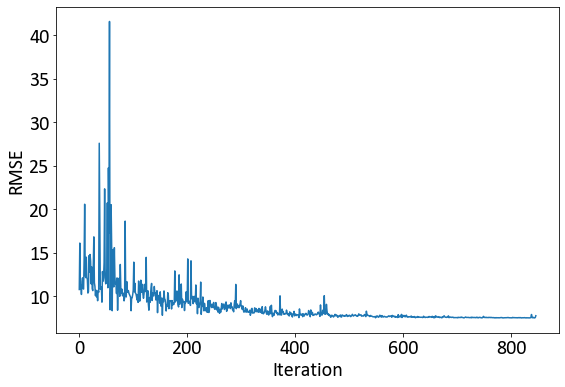

In [42]:
#Plot how the objective function was minimized during sampling
fig= plt.figure(1,figsize=(9,6))
plt.plot(results['like1'])
plt.ylabel('RMSE')
plt.xlabel('Iteration')

如果想检查最好的模型，首先需要找到目标函数值最小的run_id

In [43]:
# Plot the best model run
#Find the run_id with the minimal objective function value
bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)

Run number 772 has the lowest objectivefunction with: 7.52


然后选择它

In [44]:
# Select best model run
best_model_run = results[bestindex]

仅针对仿真结果过滤出结果：

In [45]:
#Filter results for simulation results
fields=[word for word in best_model_run.dtype.names if word.startswith('sim')]
best_simulation = list(best_model_run[fields])

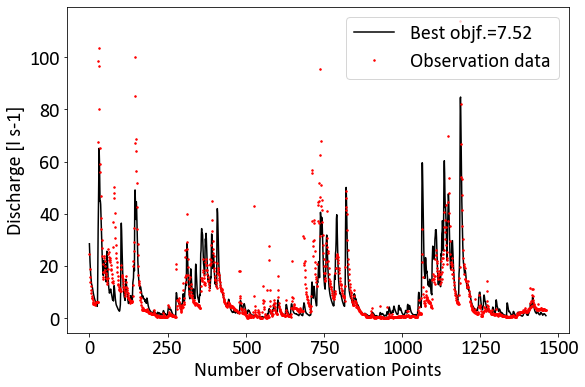

In [46]:
fig= plt.figure(figsize=(9,6))
ax = plt.subplot(1,1,1)
ax.plot(best_simulation,color='black',linestyle='solid', label='Best objf.='+str(bestobjf))
ax.plot(spot_setup.evaluation(),'r.',markersize=3, label='Observation data')
plt.xlabel('Number of Observation Points')
plt.ylabel ('Discharge [l s-1]')
plt.legend(loc='upper right')

后续再补充一些贝叶斯不确定性分析的内容。